# Multivector Search: Efficient Document Retrieval with ColPali and LanceDB Cloud

🚀 **_If you haven’t signed up for LanceDB Cloud yet, click [here](https://cloud.lancedb.com) to get started!_**

Modern documents—PDFs, scans, forms, invoices, or scientific diagrams—rely heavily on visual elements like tables, figures, and spatial layouts to convey meaning. Retrieving context from these documents poses unique challenges:  
- 🖼️ **Loss of Context**: Plain-text extraction destroys critical visual relationships (e.g., a table's structure or a diagram's annotations).  
- 🧩 **Multi-Modal Complexity**: Layouts combine text, images, and structured elements that require joint understanding.  
- 📏 **Scale vs. Precision**: Balancing pixel-perfect accuracy with efficient search across millions of documents.   

### **Why Traditional Methods Fail**  
The traditional method is a brittle, multi-stage pipeline where visual context is eroded at every step. Retrieval becomes a "best guess" based on partial text. Usually, it will involve the following steps:
1. OCR Text Extraction - extract raw text from scanned PDFs/images.
2. Layout Detection - use models like LayoutLM or rule-based tools to segment pages into regions (titles, tables, figures).
3. Structure Reconstruction - use heuristic rules or ML models try to infer reading order and hierarchy.
4. Optional: Image/Table Captioning - apply vision-language models (e.g., GPT-4V) to describe figures/tables in natural language.
5. Text Chunking - split text into fixed-size chunks or "semantic" passages (e.g., by paragraphs).
6. Embedding & Indexing- use text-based embeddings (e.g., BERT) and store in a vector DB (e.g., LanceDB).


## **Our Approach: ColPali with XTR for performant retrieval**  
ColPali (Contextualized Late Interaction Over PaliGemma [1]) enhances document retrieval by combining a vision-language model (VLM) with a multi-vector late interaction framework inspired by ColBERT [2]. In this framework, documents and queries are encoded as collections of contextualized vectors—precomputed for documents and indexed for queries. Unlike traditional methods, late interaction defers complex similarity computations between query and document vectors until the final retrieval stage, enabling nuanced semantic matching while maintaining efficiency.

To further accelerate retrieval, we integrate XTR (ConteXtualized Token Retriever [3, 4]), which prioritizes critical document tokens during initial retrieval stage and removes the gathering stage to significantly improve the performance. By focusing on the most semantically salient tokens early in the process, XTR reduces computational complexity with improved recall, ensuring rapid identification of candidate documents.

We used the [UFO dataset](https://huggingface.co/datasets/davanstrien/ufo-ColPali), a dataset with rich tables, images and text, to demonstrate how to efficiently retrieve documents with ColPali and LanceDB Cloud.



## Step 1: Install Required Libraries




In [ ]:
!pip install lancedb colpali-engine datasets tqdm

## Step 2: Obtain the API key from the [dashboard](https://cloud.lancedb.com) and Connect to LanceDB Cloud

*  Get the `db uri`

`db uri` starts with `db://`, which can be obtained from the project page on the dashboard. In the following example, `db uri` is `db://test-sfifxz`.

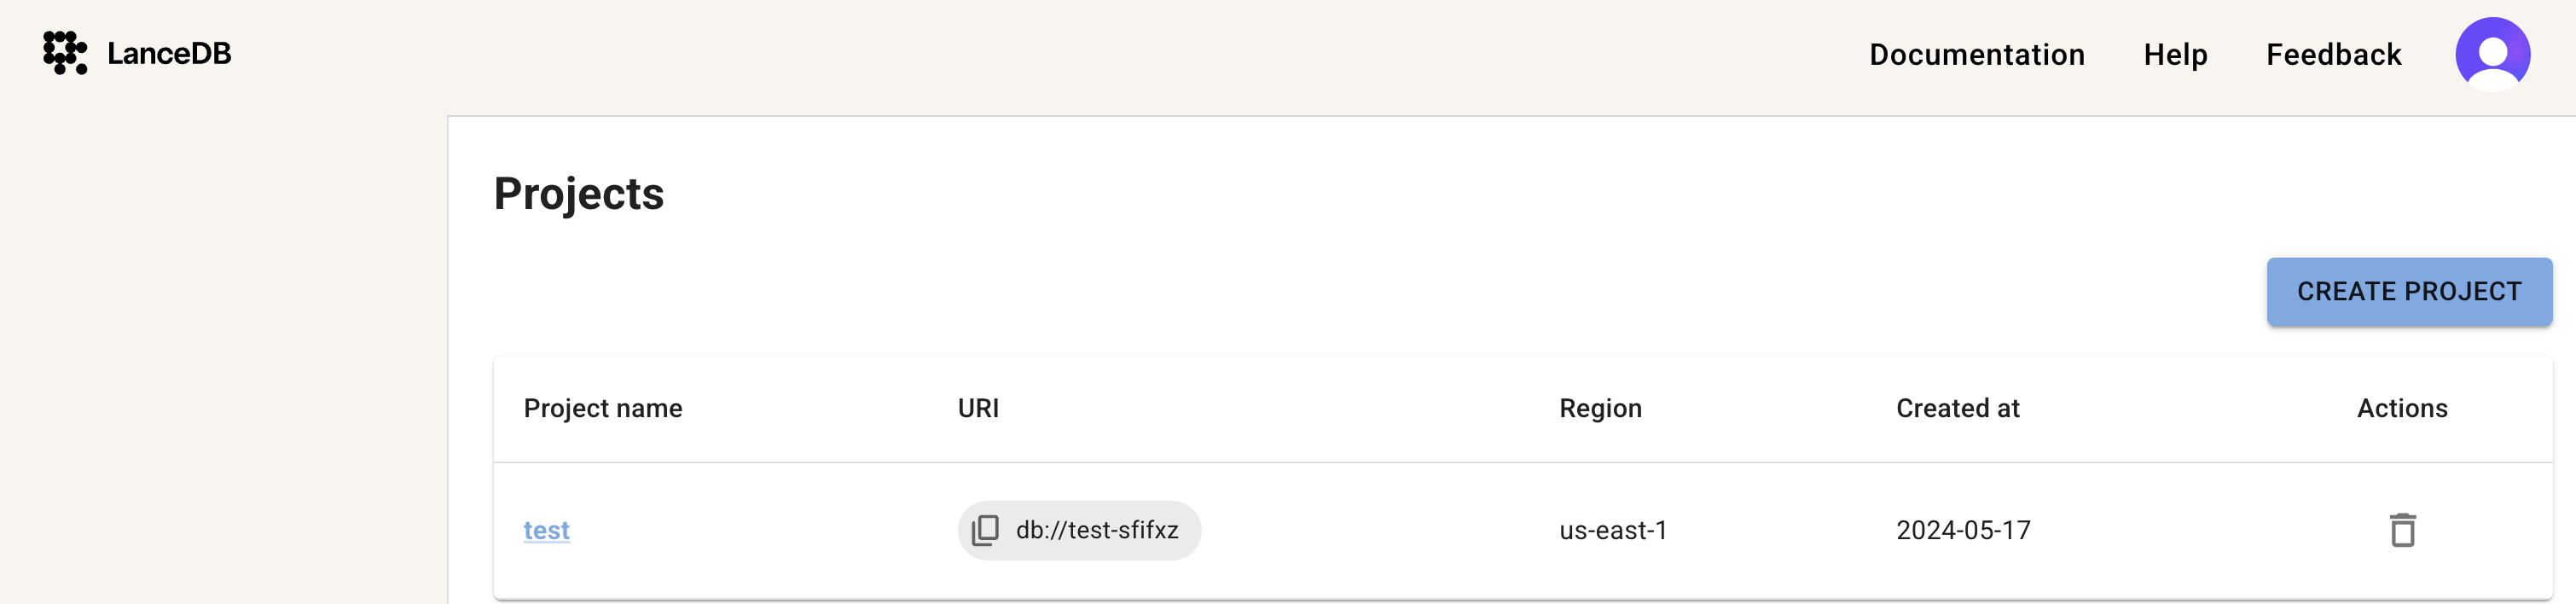

*  Get the `API Key`
Obtain a LanceDB Cloud API key by clicking on the `GENERATE API KEY` from the `table` page.

💡 Copy the code block for connecting to LanceDB Cloud that is shown at the last step of API key generation.
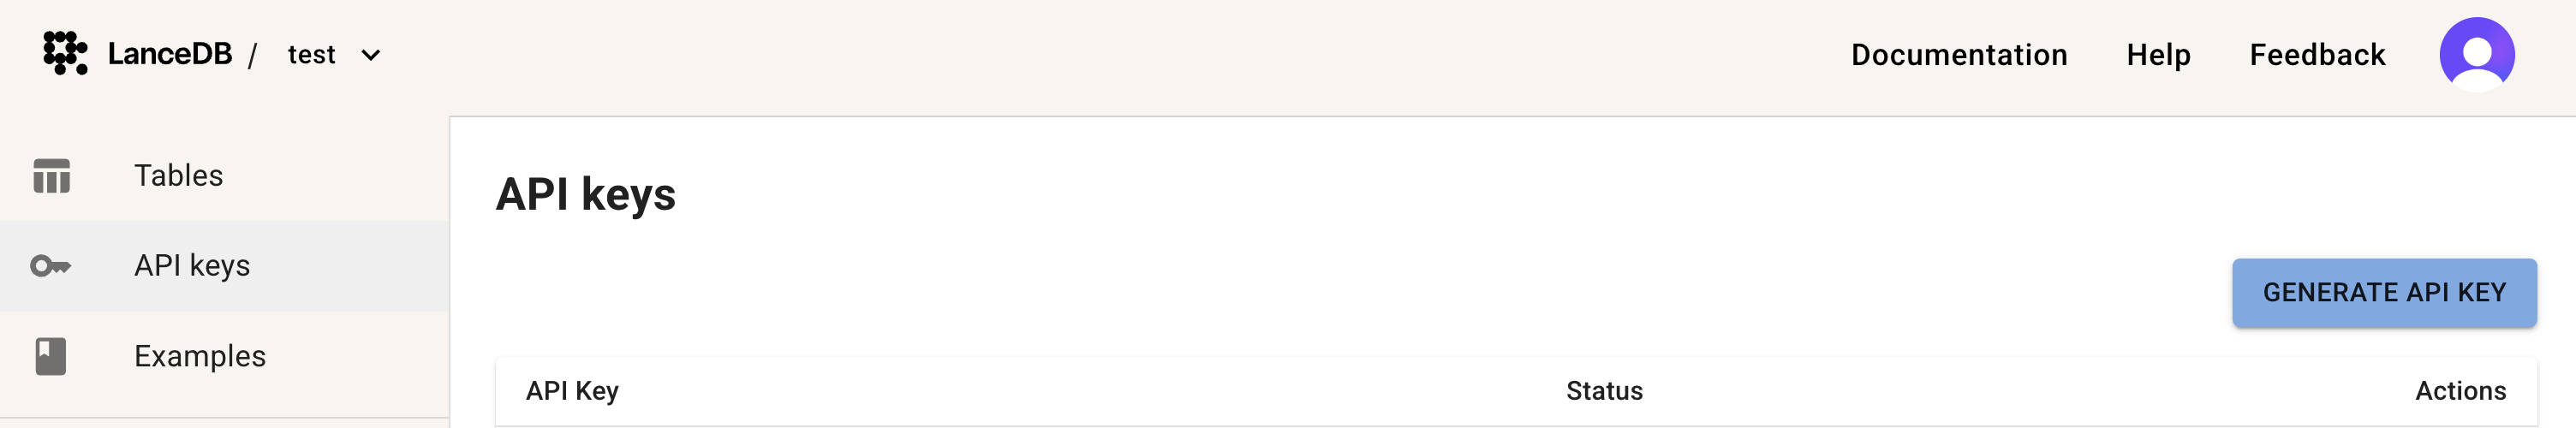

*  Connect to LanceDB Cloud

Copy and paste the `db uri` and the `api key` from the previous steps, or directly paste the code block for LanceDB Cloud connection.

In [2]:
uri = "db://your-db-uri"  # @param {type:"string"}

In [ ]:
api_key = "sk_..."  # @param {type:"string"}

## Step 3: Load the UFO dataset

The UFO dataset has 2243 rows in total with an embedding of 128 dimension each. We show an example of the document to show how complicated it is with text and images blended in the document.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/293M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2243 [00:00<?, ? examples/s]

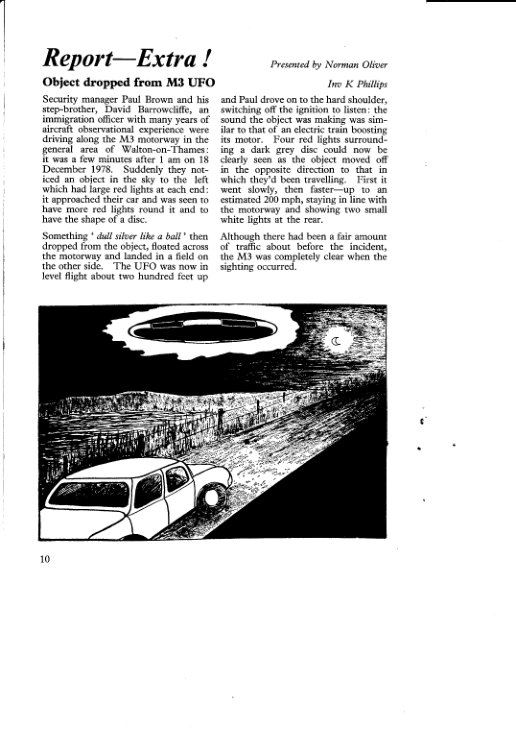

In [2]:
from math import sqrt

import pyarrow as pa
from tqdm import tqdm
import lancedb
from datasets import load_dataset
from colpali_engine.models import ColPali, ColPaliProcessor
import torch

dataset = load_dataset("davanstrien/ufo-ColPali", split="train")
dataset
dataset[333]["image"]

## Step 4: Load the ColPali model
Note: select "cuda" if you are using a Nvidia GPU or "cpu" if there is no GPU available. Mac users, please use "mps". This step can take a few minutes.

In [ ]:
# load the model
colpali_model = ColPali.from_pretrained(
    "davanstrien/finetune_colpali_v1_2-ufo-4bit",
    torch_dtype=torch.bfloat16,
    device_map="cpu",  # change to cuda if you have a Nvidia GPU, or cpu if you don't have any GPU
)
colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpaligemma-3b-pt-448-base"
)

adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/157M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

## Step 5: Connect to LanceDB Cloud



In [ ]:
api_key = api_key
uri = uri

db = lancedb.connect(
  uri=uri,
  api_key=api_key,
  region="us-east-1"
)

# define the table schema
multivector_type = pa.list_(pa.list_(pa.float32(), 128))
schema = pa.schema(
    [
        pa.field("id", pa.int64()),
        pa.field("vector", multivector_type),
    ]
)

table_name = "multivector-example"

**⚠️ WARNING: LONG EMBEDDING & INGESTION STEP**  

---

Embedding the UFO dataset and ingesting it into LanceDB takes **~2 hours on a T4 GPU**.

## Step 6: Embed the UFO dataset and ingest data into LanceDB

Note: This step will take up to 2h when running with T4 GPU with a `batch_size=4`. You can increase the `batch_size` to accelerate the process if there is more memory available, e.g. `batch_size=32` requires 60GB of memory.

In [ ]:
# create a table
table_name = "multivector-example-new"
table = db.create_table(table_name, schema=schema)

# this would take 40 mins for first run on Apple M3 Max, may be longer if you are using CPU
batch_size = 4 # low it if you have a low memory GPU
with tqdm(total=len(dataset), desc="ingesting") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]
        images = batch["image"]

        # encode the images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(
                colpali_model.device
            )
            image_embeddings = colpali_model(**batch_images)

        real_size = len(images)
        multivector = image_embeddings.cpu().float().numpy()
        multivector = pa.array(multivector.tolist(), type=multivector_type)
        data = pa.Table.from_pydict(
            {
                "id": list(range(i, i + real_size)),
                "vector": multivector,
            }
        )
        table.add(data)
        pbar.update(real_size)

## Step 7: Create an index on the multivector column
Note: LanceDB Cloud automatically infers the multivector column directly from the schema. If your dataset contains only one column with a list of vectors, no manual specification is required when building the vector index—the system handles this implicitly.


In [ ]:
# need to change when we change it to cloud
num_rows = table.count_rows()
table.create_index(
    metric="cosine",  # for now only cosine is supported for multivector
    num_partitions=int(
        sqrt(num_rows * 1030)
    ),  # it's recommended to set sqrt of the number of embeddings as the number of partitions
    num_sub_vectors=32,  # higher for accuracy, lower for speed
    index_type="IVF_PQ",
)

## Step 8: Retrieve documents from a query


In [ ]:
# search the table
queries = ["alien", "crop circles", "unidentified"]
image_results = []
for query_text in queries:
    # encode the query
    query = colpali_processor.process_queries([query_text]).to(colpali_model.device)
    query = colpali_model(**query)[0].cpu().float().numpy()
    print(f"query shape: {query.shape}")

    # search the table
    results = table.search(query).select(["id"]).limit(5).to_arrow()
    id = results["id"][0].as_py()
    image = dataset[id]["image"]
    image_results.append(image)

query shape: (15, 128)
query shape: (16, 128)
query shape: (15, 128)


# Let's see the retrieved documents!

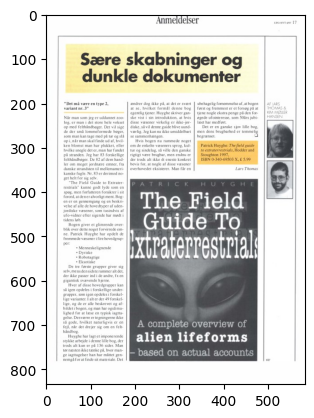

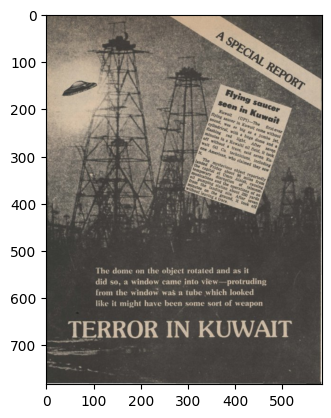

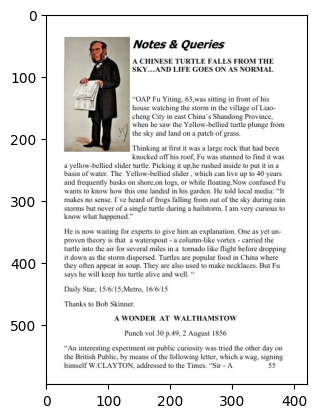

In [ ]:
import matplotlib.pyplot as plt

for image in image_results:
    plt.figure()
    plt.imshow(image)

## References
1. Manuel Faysse, Hugues Sibille, Tony Wu, Bilel Omrani, Gautier Viaud, Céline Hudelot, Pierre Colombo "ColPali: Efficient Document Retrieval with Vision Language Models". *The Thirteenth International Conference on Learning Representations*, 2025
2.Omar Khattab, Matei Zaharia, "ColBERT: Efficient and Effective Passage Search via Contextualized Late Interaction over BERT". *Proceedings of the 43rd International ACM SIGIR Conference on Research and Development in Information Retrieval*, Pages 39 - 48, 2020
3. Jinhyuk Lee, Zhuyun Dai, Sai Meher Karthik Duddu, Tao Lei, Iftekhar Naim, Ming-Wei Chang, Vincent Y. Zhao, "Rethinking the Role of Token Retrieval in Multi-Vector Retrieval", *Proceedings of the 37th International Conference on Neural Information Processing Systems*, Pages 15384 - 15405, 2023
4. Jan Luca Scheerer, Matei Zaharia, Christopher Potts, Gustavo Alonso, Omar Khattab, "WARP: An Efficient Engine for Multi-Vector Retrieval", 	*Information Retrieval*, 2025.